# Simulating and testing quantum experiments on NISQ computers using high levelquantum programming

## Import libraries and add backends

In [1]:
from qiskit import IBMQ
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import Aer, BasicAer, execute, transpile, assemble
from qiskit import quantum_info
from qiskit.circuit import Parameter
from qiskit.tools.jupyter import *
from qiskit.tools.visualization import plot_histogram, circuit_drawer
from qiskit.circuit.random import random_circuit
from collections import defaultdict
from qiskit.circuit.library import QFT
from mpl_toolkits.mplot3d import Axes3D

import os
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl

simulator = Aer.get_backend('qasm_simulator')
backend = simulator
pi = np.pi
cos = np.cos
sin = np.sin

%matplotlib inline

# 1. Quantum Eraser

The quantum eraser experiment showcases how eavesdroping and erasing the which-path information affect the interference patterns in the double-slit experiment. By using two pairs of entangled photons, one with erased which-path information and one without, we see the interference pattern recoverd for the erased case.

On the quantum circuit, the entangled photons are represented by entangled qubits. A Hadamard gate cause a superposition on q[0], then q[1] eavesdrop the which-path information (of whether q[0] were 0 or 1 after the first Hadamard). We then add a second Hadamard on the q[0] to see if there's an interference pattern: since a typical interference pattern should go 
$$|0\rangle \xrightarrow{\text{1st beamsplitter}} \frac{|0\rangle + |1\rangle}{\sqrt{2}} \xrightarrow{\text{2nd beamsplitter}} \frac{(|0\rangle + |1\rangle)+(|0\rangle - |1\rangle)}{2} = |0\rangle,$$
so a local measurement on q[0] would always measure 0, but with an eavesdropper, the interference can't happen: 
$$|0\rangle \xrightarrow{\text{1st beamsplitter}} \frac{|00\rangle + |11\rangle}{\sqrt{2}} \xrightarrow{\text{2nd beamsplitter}} \frac{(|00\rangle + |10\rangle)+(|01\rangle - |11\rangle)}{2}$$
and the local measurement on q[0] would measure 0 and 1 at 50% each, causing a diffraction. But if we erases the which-path information on q[1], we can recover the interference pattern:
$$|0\rangle \xrightarrow{\text{1st beamsplitter}} \frac{|00\rangle + |11\rangle}{\sqrt{2}} \xrightarrow{\text{2nd beamsplitter}} \frac{(|00\rangle + |10\rangle)+(|01\rangle - |11\rangle)}{2}\xrightarrow{\text{eraser}} \frac{[(|00\rangle+|01\rangle)  + (|10\rangle+|11\rangle)]+[(|00\rangle-|01\rangle) - (|10\rangle-|11\rangle)]}{2\sqrt{2}}=\frac{|00\rangle+|11\rangle}{\sqrt{2}}$$
by filtering out the result of q[0] based on the individual result of q[1].  The third Hadamard here (on q[1]) erases which-path information of whether q[0] were 0 or 1 after the first Hadamard.

In [2]:
#Citcuit without eraser
q = QuantumRegister(2)
c = ClassicalRegister(2)
qc = QuantumCircuit(q, c)

qc.h(0)
qc.cx(0,1)
qc.h(0)

qc.measure(q,c)

#Circuit with eraser
q = QuantumRegister(2)
c = ClassicalRegister(2)
qc2 = QuantumCircuit(q, c)

qc2.h(0)
qc2.cx(0,1)
qc2.h(0)
qc2.h(1) #eraser
qc2.measure(q,c)

#qc.draw()
qc2.draw()

┌───┐     ┌───┐┌─┐   
q1_0: ┤ H ├──■──┤ H ├┤M├───
      └───┘┌─┴─┐├───┤└╥┘┌─┐
q1_1: ─────┤ X ├┤ H ├─╫─┤M├
           └───┘└───┘ ║ └╥┘
c1: 2/════════════════╩══╩═
                      0  1

{'00': 2075, '11': 2056, '01': 2040, '10': 2021}
{'00': 4128, '01': 0, '10': 0, '11': 4064}


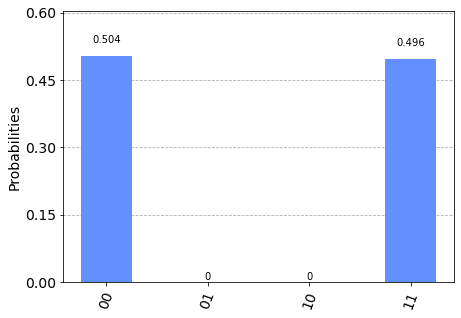

In [3]:
#Simulation
shots=8192
job = execute(qc, backend=backend, shots=shots)
#counts without eraser
counts = job.result().get_counts(qc) 

job2 = execute(qc2, backend=backend, shots=shots)
#this is to add even the zero probability cases into the result for nice visualization
counts2_draft1 = {'00': 0, '01': 0, '10': 0, '11': 0} 
counts2_draft2 = job2.result().get_counts(qc2) 
#counts with eraser
counts2 = {**counts2_draft1,**counts2_draft2} 
#counts2 = job2.result().get_counts(qc2) 
print(counts)
print(counts2)
#plot_histogram(counts) #histogram without eraser
plot_histogram(counts2) #histogram with eraser

## Import data and figures

In [4]:
shots=8192
counts = np.load(os.path.join('data','fig1','counts.npy'),allow_pickle=True).item()
counts2 = np.load(os.path.join('data','fig1','counts2.npy'),allow_pickle=True).item()

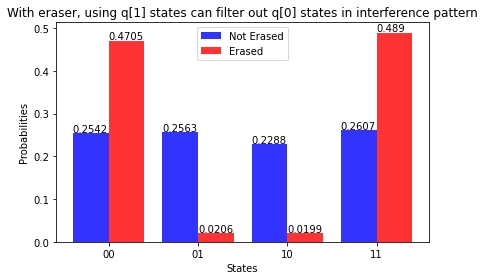

In [5]:
list1 = list(counts.values())
a = [np.round(x / shots, 4) for x in list1]
list2 = list(counts2.values())
b = [np.round(x / shots, 4) for x in list2]
names = ['00','01','10','11']

n_groups = 4
index = np.arange(n_groups)
bar_width = 0.4
opacity = 0.8

rects1 = plt.bar(index, a, bar_width, alpha=opacity, color='b', label='Not Erased')
rects2 = plt.bar(index+bar_width, b, bar_width, alpha=opacity, color='r', label='Erased')

plt.xlabel('States')
plt.ylabel('Probabilities')
plt.title('With eraser, using q[1] states can filter out q[0] states in interference pattern')
plt.xticks(index + bar_width/2, ('00', '01', '10', '11'))
plt.legend(loc='upper center')

plt.tight_layout()
for i, v in enumerate(a):
    plt.text(index[i] - 0.2, v + 0.003, str(v))
for m, n in enumerate(b):
    plt.text(index[m] + 0.2, n + 0.003, str(n))

plt.show()

Interference is 0 or 1 (H->H return to 0 because q[0] interfere with itself), and diffraction is 0 and 1 (H-CX-H i.e., CX stop q[0] from interfering with itself.)
Looking at q[1] states seperately, we filter out interference pattern.

## Figure 1

### Not erased case

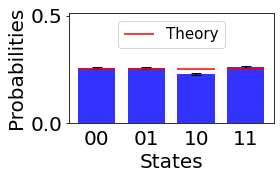

In [6]:
list1 = list(counts.values())
sigma = 1
a = [np.round(x / shots, 4) for x in list1] #probability of states
aerr=[sigma*np.sqrt((x*(1-x/shots)**2+(shots-x)*(0-x/shots)**2)/((shots-1)*shots)) for x in list1] #1 std, assuming binomial
names = ['00','01','10','11']

fig = plt.figure(figsize=(4,2.5))
ax = fig.add_subplot(111)
n_groups = 4
index = np.arange(n_groups)
bar_width = 0.75
opacity = 0.8

rects1 = plt.bar(index+bar_width/2, a, bar_width, alpha=opacity, color='b')
plt.errorbar(index+bar_width/2,a,yerr=aerr,ls='none',color='k', capsize=5)
#rects2 = plt.bar(index+bar_width, b, bar_width, alpha=opacity, color='r', label='Erased')

plt.ylim(bottom=0, top = 0.51)
plt.xlabel('States',size=20)
plt.ylabel('Probabilities',size=20)
#plt.title('Distirbution')
plt.xticks(index + bar_width/2, ('00', '01', '10', '11'))
plt.tick_params(axis="x", labelsize=20,bottom=False)
plt.tick_params(axis="y", labelsize=20)

plt.hlines(0.25, 0, 0.75, color='red', linestyle='solid', label = 'Theory')
plt.hlines(0.25, 1, 1.75, color='red', linestyle='solid')
plt.hlines(0.25, 2, 2.75, color='red', linestyle='solid')
plt.hlines(0.25, 3, 3.75, color='red', linestyle='solid')
plt.legend(loc='upper center',fontsize=15)
plt.tight_layout()

#show probabilies on top
#Not Erased
#for i, v in enumerate(a):
#    plt.text(index[i]+0.1, v + 0.003, str(v))
#Erased
#for m, n in enumerate(b):
#    plt.text(index[m] + 0.2, n + 0.003, str(n))

plt.savefig('figure/1ErasedNot.svg', transparent = True, dpi=128)
plt.show()


### Erased

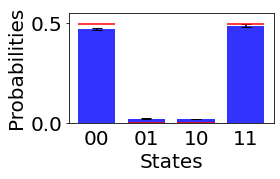

In [7]:
list2 = list(counts2.values())
b = [np.round(x / shots, 4) for x in list2] #probability of states
berr=[sigma*np.sqrt((x*(1-x/shots)**2+(shots-x)*(0-x/shots)**2)/((shots-1)*shots)) for x in list2] #1 std, assuming binomial
names = ['00','01','10','11']

fig = plt.figure(figsize=(4,2.5))
ax = fig.add_subplot(111)
n_groups = 4
index = np.arange(n_groups)
bar_width = 0.75
opacity = 0.8

rects2 = plt.bar(index+bar_width/2, b, bar_width, alpha=opacity, color='b')
plt.errorbar(index+bar_width/2,b,yerr=berr,ls='none',color='k', capsize=5)

plt.ylim(bottom=0, top = 0.55)
plt.xlabel('States',size=20)
plt.ylabel('Probabilities',size=20)
#plt.title('Distribution')
plt.xticks(index + bar_width/2, ('00', '01', '10', '11'))
plt.tick_params(axis="x", labelsize=20,bottom=False)
plt.tick_params(axis="y", labelsize=20)

plt.hlines(0.499, 0, 0.75, color='red', linestyle='solid', label = 'Theory')
plt.hlines(0.001, 1, 1.75, color='red', linestyle='solid')
plt.hlines(0.001, 2, 2.75, color='red', linestyle='solid')
plt.hlines(0.499, 3, 3.75, color='red', linestyle='solid')
#plt.legend(loc='upper center',fontsize=15)
plt.tight_layout()

#shot probabilities on top
#Not Erased
#for i, v in enumerate(a):
#    plt.text(index[i]+0.1, v + 0.003, str(v))
#Erased
#for m, n in enumerate(b):
#    plt.text(index[m] + 0.2, n + 0.003, str(n))

plt.savefig('figure/1Erased.svg', transparent = True, dpi=128)
plt.show()

# 2. Elitzur-Vaidman Bomb

A bomb is a measurement/entanglement, depicts by q[1] in the circuit. The fact that q[0] is measured/entangled and loses its purity because of entanglement with q[1] is observed on the final detectors, similar to how quantum encryption works. With a faulty bomb, the photon can freely move through both parts of the MZI, and it is depict by q[0] being able to freely interfere with itself in circuit qc0. In qc1, that is not the case, as there is a bomb that blocks one path, and will explode if the photon pass through the lower path, or in the circuit q[0] being at 1.

In [8]:
#Without bomb/faulty bomb
q = QuantumRegister(2)
c = ClassicalRegister(2)
qc0 = QuantumCircuit(q, c)

qc0.h(0)
qc0.h(0)

qc0.measure(q,c)

#With bomb/working bomb
q = QuantumRegister(2)
c = ClassicalRegister(2)
qc1 = QuantumCircuit(q, c)

qc1.h(0)
qc1.cx(q[0],q[1])
qc1.h(0)

qc1.measure(q,c)

#qc0.draw()
qc1.draw()

┌───┐     ┌───┐┌─┐
q25_0: ┤ H ├──■──┤ H ├┤M├
       └───┘┌─┴─┐└┬─┬┘└╥┘
q25_1: ─────┤ X ├─┤M├──╫─
            └───┘ └╥┘  ║ 
 c3: 2/════════════╩═══╩═
                   1   0

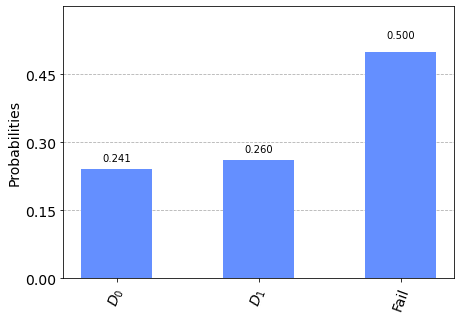

In [9]:
shots = 8192
job_sim0 = execute(qc0, backend=backend, shots = shots)
countssim0 = job_sim0.result().get_counts(qc0)
job_sim1 = execute(qc1, backend=backend, shots = shots)
countssim1 = job_sim1.result().get_counts(qc1)
counts2_draft1 = {'00': 0, '01': 0, '10': 0, '11': 0}
counts2_draft2 = countssim0
countssim0 = {**counts2_draft1,**counts2_draft2}


statesim0 = defaultdict(dict)
#We group up cases when q[1] is detected as 1 as failed (exploded) experiments.
explodes = sum((v for k, v in countssim0.items() if (k[0]=='1')), 0)
#If q[0] is still at 0, we don't detect effect of eavesdropper
d_0undetectbombs = sum((v for k, v in countssim0.items() if k.startswith(('00'))), 0)
#If q[1] is at 1, we detect effect of eavesdropper
d_1detectbombs = sum((v for k, v in countssim0.items() if k.startswith(('01'))), 0)

#Put everything in a dictionary
statesim0.update([('Fail', explodes),
                 ('$D_1$', d_1detectbombs),
                 ('$D_0$', d_0undetectbombs)])
#Calculate efficiency. Without a bomb, there is neither detection nor explosion, so it's 0/0.
#ratiosim0=d_1detectbombs/(d_1detectbombs+explodes)

statesim1 = defaultdict(dict)
#We group up cases when q[1] is detected as 1 as failed (exploded) experiments.
explodes = sum((v for k, v in countssim1.items() if (k[0]=='1')), 0)
#If q[0] is still at 0, we don't detect effect of eavesdropper
d_0undetectbombs = sum((v for k, v in countssim1.items() if k.startswith(('00'))), 0)
#If q[1] is at 1, we detect effect of eavesdropper
d_1detectbombs = sum((v for k, v in countssim1.items() if k.startswith(('01'))), 0)

#Put everything in a dictionary
statesim1.update([('Fail', explodes),
                 ('$D_1$', d_1detectbombs),
                 ('$D_0$', d_0undetectbombs)])
#Calculate efficiency
ratiosim1=d_1detectbombs/(d_1detectbombs+explodes)

#Without bomb
#plot_histogram(countssim0) #explicit distribution of each states
#plot_histogram(statesim0) #distribution of detection, undetection, and explosion

#With bomb
#plot_histogram(countssim1) #explicit distribution of each states
plot_histogram(statesim1) #distribution of detection, undetection, and explosion

## Figure 2 and data import

In [10]:
pi = np.pi
cos = np.cos
sin = np.sin
tan = np.tan

theta = np.linspace(5/100,95/100,75)

#1 duplicate
dup = range(4)

#2 backend
backend_array = ['burlington', 'essex', 'london','ourense','vigo', 'valencia','x2']
print(backend_array)

counts = {}
y=0

for b in backend_array:
    if b == 'burlington' or b == 'essex':
        sumallday = ['0','1','2','3','4','5','6','7','8','9']
    elif b == 'london':
        sumallday = ['0','1','2','3','4','5','6','7']
    elif b == 'ourense' or b == 'vigo':
        sumallday = ['0','1','2','3','4','5']
    elif b == 'valencia':
        sumallday = ['0','1','2','3']
    elif b == 'x2':
        sumallday = ['0','1','2','3','4','5','6']
    else:
        sumallday = ['1','2','3','4','5']
    counts[y] = {}
    t=0
    for n in sumallday:
        counts[y][t] = np.load(os.path.join('data', 'fig2', 'counts1_%s%s.npy'% (b,n)),allow_pickle=True).item()
        t+=1
    y+=1

ratio = {}
ratio_original = {}

def ppsum(y,a,t):
    
    explode = sum((v for k, v in counts[y][t][a].items() if not k.startswith((1)*'0')), 0)
    d_0undetectbomb = sum((v for k, v in counts[y][t][a].items() if k.startswith(((1)*'0'+'1'))), 0)
    d_1detectbomb = sum((v for k, v in counts[y][t][a].items() if k.startswith(((2)*'0'))), 0)
    
    if ((d_1detectbomb+explode) == 0):
        explode=0.000000001

    ratio[y][t][a]=d_1detectbomb/(d_1detectbomb+explode)
    ratio_original[y][t][a]=d_1detectbomb/(d_1detectbomb+explode+d_0undetectbomb)
    return ratio[y][t][a], ratio_original[y][t][a]

y=0
ratio = {}
ratio_original = {}

for b in backend_array:

    if b == 'burlington' or b == 'essex':
        sumallday = ['0','1','2','3','4','5','6','7','8','9']
    elif b == 'london':
        sumallday = ['0','1','2','3','4','5','6','7']
    elif b == 'ourense' or b == 'vigo':
        sumallday = ['0','1','2','3','4','5']
    elif b == 'valencia':
        sumallday = ['0','1','2','3']
    elif b == 'x2':
        sumallday = ['0','1','2','3','4','5','6']
    else:
        sumallday = ['1','2','3','4','5']

    ratio[y] = {}
    ratio_original[y] = {}

    t=0
    for n in sumallday:
        ratio[y][t] = {}
        ratio_original[y][t] = {}

        a=0                
        for l in dup:
            ratio[y][t][a] = {}
            ratio_original[y][t][a] = {}
            ratio[y][t][a], ratio_original[y][t][a] = ppsum(y,a,t)
            a+=1
        t+=1
    y+=1

['burlington', 'essex', 'london', 'ourense', 'vigo', 'valencia', 'x2']


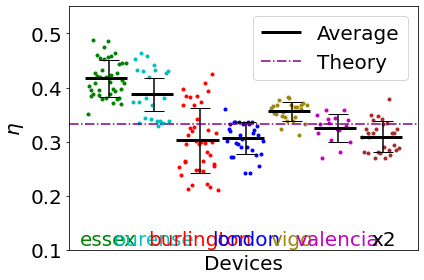

In [11]:
d1, d2, d3, d4, = [],[],[],[]
average = []

i=0
for b in backend_array:
    
    if b == 'burlington' or b == 'essex':
        sumallday = ['0','1','2','3','4','5','6','7','8','9']
    elif b == 'london':
        sumallday = ['0','1','2','3','4','5','6','7']
    elif b == 'ourense' or b == 'vigo':
        sumallday = ['0','1','2','3','4','5']
    elif b == 'valencia':
        sumallday = ['0','1','2','3']
    elif b == 'x2':
        sumallday = ['0','1','2','3','4','5','6']
    else:
        sumallday = ['1','2','3','4','5']
    j=0
    a=0
    for n in sumallday:
        d1.append(ratio[i][j][0])
        d2.append(ratio[i][j][1])
        d3.append(ratio[i][j][2])
        d4.append(ratio[i][j][3])
        a=a+((ratio[i][j][0]+ratio[i][j][1]+ratio[i][j][2]+ratio[i][j][3])/4)
        j+=1
    average.append(a/len(sumallday))
    i+=1

fig = plt.figure(figsize=(6,4))
ax = plt.subplot(111)

bar_width = 0.05
opacity = 0.8

#burlington
n_start = 0
n_groups = 10
j=0
i=2.5
index = np.arange(0+i,1+i,1/(n_groups-n_start))
plt.plot(index - 1.5*bar_width, d1[n_start:n_groups], 'r.')
plt.plot(index - 0.5*bar_width, d2[n_start:n_groups], 'r.')
plt.plot(index + 0.5*bar_width, d3[n_start:n_groups], 'r.')
plt.plot(index + 1.5*bar_width, d4[n_start:n_groups], 'r.')
#plt.plot(i+0.5, average[j], 'k', marker ='h', ls = '',markersize=12)
plt.hlines(average[j],i-0.15,i+1,'k',linewidth=3,ls='solid', label = 'Average')
mergeall = d1[n_start:n_groups]+d2[n_start:n_groups]+d3[n_start:n_groups]+d4[n_start:n_groups]

#-----Calculate std------
#variance from 40 tests
var1=np.var(mergeall) 
#variance from 8192 shots of each test
var2=(average[j]*(1-average[j])**2+(1-average[j])*(0-average[j])**2)/8192
std = np.sqrt(var1+var2)
plt.errorbar(i+0.5, average[j], yerr=std,color='k',capsize = 10)

#essex
n_start = 10
n_groups = 20
j=1
i=0
index = np.arange(0+i,1+i,1/(n_groups-n_start))
plt.plot(index - 1.5*bar_width, d1[n_start:n_groups], 'g.')
plt.plot(index - 0.5*bar_width, d2[n_start:n_groups], 'g.')
plt.plot(index + 0.5*bar_width, d3[n_start:n_groups], 'g.')
plt.plot(index + 1.5*bar_width, d4[n_start:n_groups], 'g.')
#plt.plot(i+0.5, average[j], 'k', marker ='h', ls = '',markersize=12)
plt.hlines(average[j],i-0.15,i+1,'k',linewidth=3,ls='solid')
mergeall = d1[n_start:n_groups]+d2[n_start:n_groups]+d3[n_start:n_groups]+d4[n_start:n_groups]

#-----Calculate std------
#variance from 40 tests
var1=np.var(mergeall) 
#variance from 8192 shots of each test
var2=(average[j]*(1-average[j])**2+(1-average[j])*(0-average[j])**2)/8192
std = np.sqrt(var1+var2)
plt.errorbar(i+0.5, average[j], yerr=std,color='k',capsize = 10)

#london
n_start = 20
n_groups = 28
j=2
i=3.75
index = np.arange(0+i,1+i,1/(n_groups-n_start))
plt.plot(index - 1.5*bar_width, d1[n_start:n_groups], 'b', marker ='.', ls = '')
plt.plot(index - 0.5*bar_width, d2[n_start:n_groups], 'b', marker ='.', ls = '')
plt.plot(index + 0.5*bar_width, d3[n_start:n_groups], 'b', marker ='.', ls = '')
plt.plot(index + 1.5*bar_width, d4[n_start:n_groups], 'b', marker ='.', ls = '')
#plt.plot(i+0.5, average[j], 'k', marker ='h', ls = '',markersize=12)
plt.hlines(average[j],i-0.15,i+1,'k',linewidth=3,ls='solid')
mergeall = d1[n_start:n_groups]+d2[n_start:n_groups]+d3[n_start:n_groups]+d4[n_start:n_groups]

#-----Calculate std------
#variance from 40 tests
var1=np.var(mergeall) 
#variance from 8192 shots of each test
var2=(average[j]*(1-average[j])**2+(1-average[j])*(0-average[j])**2)/8192
std = np.sqrt(var1+var2)
plt.errorbar(i+0.5, average[j], yerr=std,color='k',capsize = 10)

#ourense
n_start = 28
n_groups = 34
j=3
i=1.25
index = np.arange(0+i,1+i,1/(n_groups-n_start))
plt.plot(index - 1.5*bar_width, d1[n_start:n_groups], 'c.')
plt.plot(index - 0.5*bar_width, d2[n_start:n_groups], 'c.')
plt.plot(index + 0.5*bar_width, d3[n_start:n_groups], 'c.')
plt.plot(index + 1.5*bar_width, d4[n_start:n_groups], 'c.')
#plt.plot(i+0.5, average[j], 'k', marker ='h', ls = '',markersize=12)
plt.hlines(average[j],i-0.15,i+1,'k',linewidth=3,ls='solid')

#-----Calculate std------
#variance from 40 tests
var1=np.var(mergeall) 
#variance from 8192 shots of each test
var2=(average[j]*(1-average[j])**2+(1-average[j])*(0-average[j])**2)/8192
std = np.sqrt(var1+var2)
plt.errorbar(i+0.5, average[j], yerr=std,color='k',capsize = 10)


#vigo
n_start = 34
n_groups = 40
j=4
i=5
index = np.arange(0+i,1+i,1/(n_groups-n_start))
plt.plot(index - 1.5*bar_width, d1[n_start:n_groups], '#9b870c', marker ='.', ls = '')
plt.plot(index - 0.5*bar_width, d2[n_start:n_groups], '#9b870c', marker ='.', ls = '')
plt.plot(index + 0.5*bar_width, d3[n_start:n_groups], '#9b870c', marker ='.', ls = '')
plt.plot(index + 1.5*bar_width, d4[n_start:n_groups], '#9b870c', marker ='.', ls = '')
#plt.plot(i+0.5, average[j], 'k', marker ='h', ls = '',markersize=12)
plt.hlines(average[j],i-0.15,i+1,'k',linewidth=3,ls='solid')
mergeall = d1[n_start:n_groups]+d2[n_start:n_groups]+d3[n_start:n_groups]+d4[n_start:n_groups]

#-----Calculate std------
#variance from 40 tests
var1=np.var(mergeall) 
#variance from 8192 shots of each test
var2=(average[j]*(1-average[j])**2+(1-average[j])*(0-average[j])**2)/8192
std = np.sqrt(var1+var2)
plt.errorbar(i+0.5, average[j], yerr=std,color='k',capsize = 10)

#valencia
n_start = 40
n_groups = 44
j=5
i=6.25
index = np.arange(0+i,1+i,1/(n_groups-n_start))
plt.plot(index - 1.5*bar_width, d1[n_start:n_groups], 'm.')
plt.plot(index - 0.5*bar_width, d2[n_start:n_groups], 'm.')
plt.plot(index + 0.5*bar_width, d3[n_start:n_groups], 'm.')
plt.plot(index + 1.5*bar_width, d4[n_start:n_groups], 'm.')
#plt.plot(i+0.5, average[j], 'k', marker ='h', ls = '',markersize=12)
plt.hlines(average[j],i-0.15,i+1,'k',linewidth=3,ls='solid')
mergeall = d1[n_start:n_groups]+d2[n_start:n_groups]+d3[n_start:n_groups]+d4[n_start:n_groups]

#-----Calculate std------
#variance from 40 tests
var1=np.var(mergeall) 
#variance from 8192 shots of each test
var2=(average[j]*(1-average[j])**2+(1-average[j])*(0-average[j])**2)/8192
std = np.sqrt(var1+var2)
plt.errorbar(i+0.5, average[j], yerr=std,color='k',capsize = 10)

#x2
n_start = 44
n_groups = 51
j=6
i=7.5
index = np.arange(0+i,1+i,1/(n_groups-n_start))
plt.plot(index - 1.5*bar_width, d1[n_start:n_groups], 'brown', marker ='.', ls = '')
plt.plot(index - 0.5*bar_width, d2[n_start:n_groups], 'brown', marker ='.', ls = '')
plt.plot(index + 0.5*bar_width, d3[n_start:n_groups], 'brown', marker ='.', ls = '')
plt.plot(index + 1.5*bar_width, d4[n_start:n_groups], 'brown', marker ='.', ls = '')
#plt.plot(i+0.5, average[j], 'k', marker ='h', ls = '',markersize=12)
plt.hlines(average[j],i-0.15,i+1,'k',linewidth=3,ls='solid')
mergeall = d1[n_start:n_groups]+d2[n_start:n_groups]+d3[n_start:n_groups]+d4[n_start:n_groups]

#-----Calculate std------
#variance from 40 tests
var1=np.var(mergeall) 
#variance from 8192 shots of each test
var2=(average[j]*(1-average[j])**2+(1-average[j])*(0-average[j])**2)/8192
std = np.sqrt(var1+var2)
plt.errorbar(i+0.5, average[j], yerr=std,color='k',capsize = 10)

#-----------------------------------------------
plt.xlabel('Devices',size=20)
plt.ylabel('$\eta$',size=20)
#plt.title('Detection rate on each pair on each backend')
plt.ylim(bottom=0.1, top = 0.55)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,  # labels along the bottom edge are off
    direction="in", pad=-20, labelsize=20) 

plt.tick_params(axis="y", labelsize=20)
ax.get_xticklabels()[0].set_color("g")
ax.get_xticklabels()[1].set_color("c")
ax.get_xticklabels()[2].set_color("r")
ax.get_xticklabels()[3].set_color("b")
ax.get_xticklabels()[4].set_color("#9b870c")
ax.get_xticklabels()[5].set_color("m")
ax.get_xticklabels()[6].set_color("k")
plt.xticks(np.arange(7)*1.25+0.5, (backend_array[1],backend_array[3],backend_array[0],backend_array[2]\
                  ,backend_array[4],backend_array[5],backend_array[6]))


plt.axhline(y=1/3, color='purple', linestyle='dashdot', label = 'Theory')
plt.legend(loc='upper right',fontsize=20)
plt.tight_layout()
#plt.show()
plt.savefig('figure/2Hplot.svg', transparent = True, dpi=240)

# 3. Kwiat's bomb tester

We can increase detection efficiency by changing the transmitivity of beamsplitters (angles of Ry), increasing the number of beamsplitters (numbers of Ry). Either way, the angles need 
to satisfy the condition $$\sum_{i=1}^N\theta_i=\pi.$$

We can approach the maximum efficiency even faster by doing both. In that case, we take the angle of the final Ry (transmitivity of beamsplitters) be $\theta_N$, and of the other Ry $\theta_i$. Then, the efficiency is

$$\eta=\frac{\sin^2(\theta_N/2)\prod_{i=1}^{N-1}\cos^2(\theta_i/2)}{1-\prod_{i=1}^N\cos^2(\theta_i/2)}.$$

In [12]:
#parameter for angles of Ry
t3 = Parameter('t3')  
#list of angles of Ry, we take max at 0.8 to avoid fluctuation
theta3 = np.linspace(0,0.8,75) 
#list of numbers of Ry, max at 6 because a real device only has 5 qubits; for simulation, add more
layer3 = np.arange(2,6) 
#dictionary of all circuits
qc3 = defaultdict(dict) 

#function for each stage of Ry, so that all the angles add up to pi
def stageKR2(a,n,t):
    qc3_layer.ry((pi-pi*t)/(n-1),q3[0])
    qc3_layer.cx(q3[0],q3[a])
    qc3_layer.measure(q3[a], c3[a])
    
n=1
k=1
q3 = QuantumRegister(n)
c3 = ClassicalRegister(n)
qc3_layer = QuantumCircuit(q3, c3)

k=0
for n in layer3: #n is the number of Ry
    
    a = 1
    q3 = QuantumRegister(n)
    c3 = ClassicalRegister(n)
    qc3_layer = QuantumCircuit(q3, c3)

    while a+1 <= n:
        stageKR2(a,n,t3)
        a += 1

    qc3_layer.ry(pi*t3,q3[0]) #the last Ry, so that all the angles add up to pi
    qc3_layer.measure(q3[0], c3[0])
    qc3[k] = [qc3_layer.bind_parameters({t3: t3_val}) for t3_val in theta3]
    k+=1
    
qc3_layer.draw()

┌──────────────────┐     ┌──────────────────┐     ┌──────────────────┐»
q48_0: ┤ Ry(π/4 - π/4*t3) ├──■──┤ Ry(π/4 - π/4*t3) ├──■──┤ Ry(π/4 - π/4*t3) ├»
       └──────────────────┘┌─┴─┐└───────┬─┬────────┘  │  └──────────────────┘»
q48_1: ────────────────────┤ X ├────────┤M├───────────┼──────────────────────»
                           └───┘        └╥┘         ┌─┴─┐        ┌─┐         »
q48_2: ──────────────────────────────────╫──────────┤ X ├────────┤M├─────────»
                                         ║          └───┘        └╥┘         »
q48_3: ──────────────────────────────────╫────────────────────────╫──────────»
                                         ║                        ║          »
q48_4: ──────────────────────────────────╫────────────────────────╫──────────»
                                         ║                        ║          »
 c8: 5/══════════════════════════════════╩════════════════════════╩══════════»
                                         1                        2          »
«            ┌──────────────────┐     ┌──────────┐┌─┐
«q48_0: ──■──┤ Ry(π/4 - π/4*t3) ├──■──┤ Ry(π*t3) ├┤M├
«         │  └──────────────────┘  │  └──────────┘└╥┘
«q48_1: ──┼────────────────────────┼───────────────╫─
«         │                        │               ║ 
«q48_2: ──┼────────────────────────┼───────────────╫─
«       ┌─┴─┐        ┌─┐           │               ║ 
«q48_3: ┤ X ├────────┤M├───────────┼───────────────╫─
«       └───┘        └╥┘         ┌─┴─┐    ┌─┐      ║ 
«q48_4: ──────────────╫──────────┤ X ├────┤M├──────╫─
«                     ║          └───┘    └╥┘      ║ 
« c8: 5/══════════════╩════════════════════╩═══════╩═
«                     3                    4       0

In [13]:
shots = 8192
countssim3 = defaultdict(dict)
k=0
for l in layer3:
    print(l) #print number of layers to check progress
    job_sim3 = execute(qc3[k], backend=simulator, shots=shots)
    countssim3[k] = [job_sim3.result().get_counts(i) for i in range(len(job_sim3.result().results))]
    k+=1

statesim3 = {}
ratiosim3 = {}

k=0
for l in layer3:
    i=0
    statesim3[l-2] = {}
    ratiosim3[l-2] = {}
    for t in theta3:
        statesim3[l-2][i] = {}
        ratiosim3[l-2][i] = {}
        explode = sum((v for k, v in countssim3[l-2][i].items() if not k.startswith((l-1)*'0')), 0)
        d_0undetectbomb = sum((v for k, v in countssim3[l-2][i].items() if k.startswith(((l-1)*'0'+'1'))), 0)
        d_1detectbomb = sum((v for k, v in countssim3[l-2][i].items() if k.startswith((l*'0'))), 0)
        
        #sanity check to make sure the total number of cases == number of trials
        if ((d_1detectbomb+explode+d_0undetectbomb) != shots):
            print('not 8192')
        #failsafe against zero division for ratiosim3
        if ((d_1detectbomb+explode) == 0):
            explode=0.0000000000001
        
        statesim3[l-2][i].update([('explode', explode),
                      ('d_0 undetect bomb', d_0undetectbomb),
                      ('d_1 detect bomb', d_1detectbomb)])
        ratiosim3[l-2][i]=d_1detectbomb/(d_1detectbomb+explode)

        i+=1
    k+=1

2
3
4
5


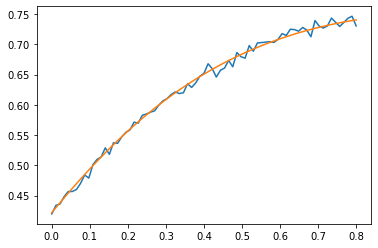

In [14]:
# Detection efficiency to the angles of the final BS (theta3) and number of BS
# Formula (4)
number_of_bs = 4
x = theta3
plt.plot(x,ratiosim3[number_of_bs-2].values())
def f(x, y):
    x_i = (1-x)/(y-1) #angles of the previous BS
    z = np.cos(0.5*pi*x)**2*np.cos(0.5*pi*x_i)**(2*(y-1))/(1-np.sin(0.5*pi*x)**2*np.cos(0.5*pi*x_i)**(2*(y-1)))
    return z

plt.plot(x,f(x,number_of_bs))

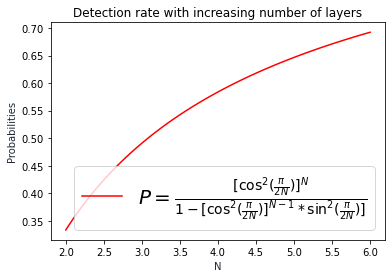

In [15]:
#Formula (2)
x = np.linspace(2,6,100)
y = (np.cos(pi/(2*x)))**(2*x)/(1-(np.cos(pi/(2*x)))**(2*(x-1))*(np.sin(pi/(2*x)))**(2))
plt.plot(x, y, '-r', label=r'$P=\frac{[\cos ^2 (\frac{\pi}{2N})]^N}{1-[\cos ^2 (\frac{\pi}{2N})]^{N-1}*\sin ^2 (\frac{\pi}{2N})]}}$')
plt.title('Detection rate with increasing number of layers')
plt.xlabel('N', color='#1C2833')
plt.ylabel('Probabilities', color='#1C2833')
plt.legend(loc='lower right',fontsize=20)
#plt.grid()
plt.show()

## Figure 3 and data import

In [16]:
import pandas as pd

repeat = np.arange(10)
backend = 'valencia'
ratio45= {}
l2, l3, l4, l5 = [],[],[],[] #original ratio
l2_nk, l3_nk, l4_nk, l5_nk = [],[],[],[] #list of lists, no key only ratio, to calculate std

for i in repeat:
    l=np.load(os.path.join('data', 'fig3', 'ratio45_%s%s.npy' % (backend, i)),allow_pickle=True).item()
    
    #import all ratio, list of dicts
    l2.append(l[0])
    l3.append(l[1])
    l4.append(l[2])

    l5.append(l[3])
    
    #list of lists, no key only ratio, to calculate std
    l2_nk.append(list(l[0].values()))
    l3_nk.append(list(l[1].values()))
    l4_nk.append(list(l[2].values()))
    l5_nk.append(list(l[3].values()))
    
#------------------------

import collections

counter2 = collections.Counter()
counter3 = collections.Counter() 
counter4 = collections.Counter() 
counter5 = collections.Counter() 

for d2 in l2:  
    counter2.update(d2)
for d3 in l3:  
    counter3.update(d3)
for d4 in l4:  
    counter4.update(d4)
for d5 in l5:  
    counter5.update(d5)
    
ratio45[0]=dict((x, y/10) for x, y in counter2.items())
ratio45[1]=dict((x, y/10) for x, y in counter3.items())
ratio45[2]=dict((x, y/10) for x, y in counter4.items())
ratio45[3]=dict((x, y/10) for x, y in counter5.items())

#calculate var of 
l_nk = []
l_nk.append(np.array(l2_nk,dtype=np.float64))
l_nk.append(np.array(l3_nk,dtype=np.float64))
l_nk.append(np.array(l4_nk,dtype=np.float64))
l_nk.append(np.array(l5_nk,dtype=np.float64))
l_var=[]
l_var.append(np.var(l_nk[0],axis=0))
l_var.append(np.var(l_nk[1],axis=0))
l_var.append(np.var(l_nk[2],axis=0))
l_var.append(np.var(l_nk[3],axis=0))

#calculate var of each 8192 shots
var_8192 = []
var_8192.append([(x/10*(1-x/10)**2/8191+(1-x/10)*(x/10)**2/8191)
            for x in list(counter2.values())])
var_8192.append([(x/10*(1-x/10)**2/8191+(1-x/10)*(x/10)**2/8191)
            for x in list(counter3.values())])
var_8192.append([(x/10*(1-x/10)**2/8191+(1-x/10)*(x/10)**2/8191)
            for x in list(counter4.values())])
var_8192.append([(x/10*(1-x/10)**2/8191+(1-x/10)*(x/10)**2/8191)
            for x in list(counter5.values())])

#Calculate std
from operator import add
std_3 = []
std_3.append(np.sqrt(list( map(add, l_var[0], var_8192[0]) )))
std_3.append(np.sqrt(list( map(add, l_var[1], var_8192[1]) )))
std_3.append(np.sqrt(list( map(add, l_var[2], var_8192[2]) )))
std_3.append(np.sqrt(list( map(add, l_var[3], var_8192[3]) )))

ratiosim45 = np.load(os.path.join('data', 'fig3', 'ratiosim45.npy'),allow_pickle=True).item()
countssim45 = np.load(os.path.join('data', 'fig3', 'countssim45.npy'),allow_pickle=True).item()
theta45 = np.load(os.path.join('data', 'fig3', 'theta45.npy'),allow_pickle=True)
layer45 = np.load(os.path.join('data', 'fig3', 'layer45.npy'),allow_pickle=True)
theta45exp = np.load(os.path.join('data', 'fig3', 'theta45exp.npy'),allow_pickle=True)
layer45exp = np.load(os.path.join('data', 'fig3', 'layer45exp.npy'),allow_pickle=True)

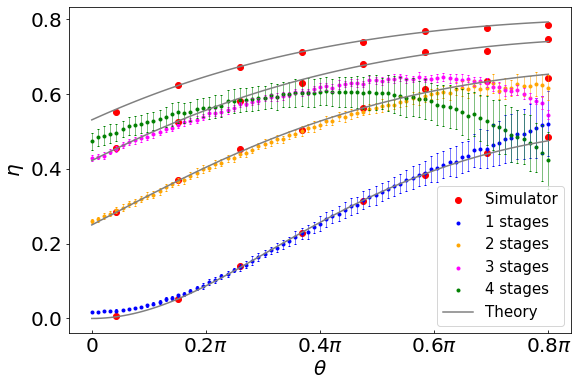

In [17]:
theta4=defaultdict(dict)
k=0
for n in layer45:
    theta4[k] = np.linspace(20/100,1,75)
    k+=1
fig = plt.figure(figsize=(9,6))
ax = plt.subplot(111)
theta = np.linspace(0,0.8,100)
theta2 = np.linspace(20/100,1,75)
z=np.array([list(inner_dict.values()) for inner_dict in ratio45.values()])
zsim = np.array([list(inner_dict.values()) for inner_dict in ratiosim45.values()])

def f(x, y):
    x_i = (1-x)/(y-1) #angles of the previous BS
    z = np.cos(0.5*pi*x)**2*np.cos(0.5*pi*x_i)**(2*(y-1))/(1-np.sin(0.5*pi*x)**2*np.cos(0.5*pi*x_i)**(2*(y-1)))
    return z

colors = ['blue', 'orange', 'magenta', 'green']
simlabel = ['Simulator', None, None, None]
theolabel = ['Theory', None, None, None]

x = theta2
y = (1-(np.sin(0.5*pi*(1-x)))**2)/(2-(np.sin(0.5*pi*(1-x)))**2)
#Simulator
for l in layer45exp:
    x= (1-(theta2))[0:76:10]
    y= zsim[l-2][0:76:10]
    plt.scatter(x, y, marker='o', color='red', label =simlabel[l-2])
#Experiments
for l in layer45exp:
    x=1-theta2
    y= z[l-2]
    plt.scatter(x, y, marker='.', color = colors[l-2], label ='%s stages'%(l-1))
    plt.errorbar(x,y,yerr=std_3[l-2],color=colors[l-2],elinewidth=0.5,capsize=1,ls='none')
    
#Theory
for l in layer45exp[0:]:
    x=theta 
    plt.plot(x, f(x,l), color='gray', linestyle='solid', label = theolabel[l-2])

x = theta
y = (1-(np.sin(0.5*pi*(1-x)))**2)/(2-(np.sin(0.5*pi*(1-x)))**2)   

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,  # labels along the bottom edge are off
    direction="in", labelsize=20) 

plt.tick_params(axis="y", labelsize=20)
plt.xlabel(r'$\theta$', size=20)
plt.ylabel(r'$\eta$', size=20)
plt.legend(loc='lower right',fontsize=15)
xlocs, xlabs = plt.xticks()
plt.xticks([0,0.2,0.4,0.6,0.8], ['0', r'$0.2 \pi$', r'$0.4 \pi$', r'$0.6 \pi$', r'$0.8 \pi$'])
#ax.set_xlim([-0.02, 0.82])
#ax.set_ylim([-0.02, 0.82])
#plt.grid()
#plt.gca().invert_xaxis()

plt.savefig('figure/3%s.svg'%(backend), dpi=240)
plt.show()

# 4. Hardy

The Hardy's experiment is an Elitzur-Vaidman bomb tester for a quantum bomb. Merging two MZI means the particle/antiparticle can disclose the presence of its counterpart in the interaction zone via showing an interference (no presence) or diffraction (presence of counter part) pattern.

For the $Ry(\pi/2)$ gate case, instead of returning the state back to its original state like a double Hadamard $|0\rangle \rightarrow |0\rangle$, a double $Ry(\pi/2)$ interfere a state to its orthonormal state $|0\rangle \rightarrow |1\rangle$ - this is our interference pattern. In fact, we can see how the loss of interference - diffraction - on q[0] can "detect" whether q[1] were in the interaction zone. We measure whether q[0] interferes with itself or not, while for q[1], we measure whether it was  in the interaction zone by 

$$|00\rangle \xrightarrow{Ry\otimes Ry} \frac{|0\rangle+ |1\rangle}{\sqrt{2}}\otimes\frac{|0\rangle +|1\rangle}{\sqrt{2}} \xrightarrow{\text{interaction}} \frac{|00\rangle}{2}+\frac{|01\rangle}{2}+\frac{|10\rangle}{2}+\frac{|\gamma \gamma\rangle}{2} \\ \xrightarrow{Ry\otimes I}  \frac{|10\rangle}{\sqrt{2}}+\frac{|01\rangle+|11\rangle}{2\sqrt{2}}+\frac{|\gamma \gamma\rangle}{2};$$

we see when q[0] is at 0 (diffraction), q[1] is always 1 (presented in the interaction zone). The counterintuitive effect, so called "Hardy's paradox", emerges when we measure the interference/diffraction pattern of both q[0] and q[1]: there's a non-zero probability of both particles being measured at $|00\rangle$, meaning they both detect each other's appearance in the interaction zone.

The probability to detect the $|00\rangle$ is called the "nonlocal probability" $\gamma$. We can change the angles of the $Ry(\theta)$ gates, so long that they add up to $\pi$, to change $\gamma$. The maximal nonlocal probability is $\gamma=\frac12(5\sqrt5-11) \approx 0.0901$ at $\theta \approx 1.809$.

In [18]:
theta = pi/2

q0 = QuantumRegister(3)
c0 = ClassicalRegister(3)
qc0 = QuantumCircuit(q0, c0)

qc0.ry(theta,q0[0:2])
qc0.ry(pi-theta,q0[0:2])

qc0.measure(q0, c0)

q = QuantumRegister(3)
c = ClassicalRegister(3)
qc1 = QuantumCircuit(q, c)

qc1.ry(theta, q[0:2])
qc1.ccx(q[0],q[1],q[2])
qc1.ry(pi-theta,q[0:2])

qc1.measure(q, c)
qc1.draw()

┌─────────┐     ┌─────────┐┌─┐   
q3362_0: ┤ Ry(π/2) ├──■──┤ Ry(π/2) ├┤M├───
         ├─────────┤  │  ├─────────┤└╥┘┌─┐
q3362_1: ┤ Ry(π/2) ├──■──┤ Ry(π/2) ├─╫─┤M├
         └─────────┘┌─┴─┐└───┬─┬───┘ ║ └╥┘
q3362_2: ───────────┤ X ├────┤M├─────╫──╫─
                    └───┘    └╥┘     ║  ║ 
  c10: 3/═════════════════════╩══════╩══╩═
                              2      0  1

{'000': 0, '001': 0, '010': 0, '011': 8192, '100': 0, '101': 0, '110': 0, '111': 0}
{'011': 4617, '100': 530, '110': 497, '000': 503, '010': 506, '111': 471, '001': 537, '101': 531}


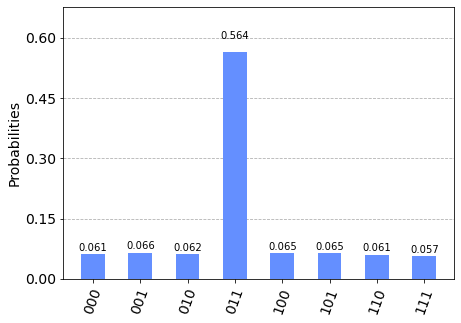

In [19]:
shots=8192
job0 = execute(qc0, backend=simulator, shots=shots)
counts0_draft1 = {'000': 0, '001': 0, '010': 0, '011': 0, '100': 0, '101': 0, '110': 0, '111': 0}
counts0_draft2 = job0.result().get_counts(qc0) 
counts0 = {**counts0_draft1,**counts0_draft2} #counts when the two MZI don't meet
job = execute(qc1, backend=simulator, shots=shots)
counts1 = job.result().get_counts(qc1) #counts when the two MZI meet
print(counts0)
print(counts1)
#plot_histogram(counts0) #histogram when the two MZI don't meet
plot_histogram(counts1) #histogram when the two MZI meet

Nonlocal probability is 0.0614013671875


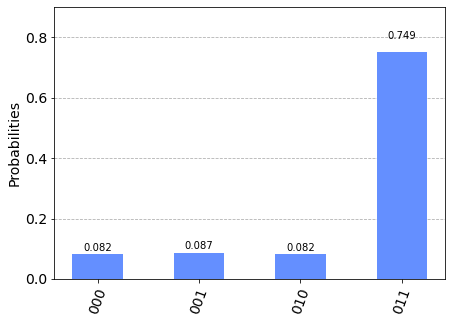

In [20]:
annihilation = 0
#remove the annihilation cases
for k, v in list(counts1.items()):
    if (k[0] == '1'):
        annihilation = annihilation + v
        del counts1[k]
#counts1['annihilation'] = annihilation

#calculate nonlocal probabilities on the probability of the |00> case
nonloc = 0
for k, v in list(counts1.items()):
    if (k[1] == k[2] == '0'):
        nonloc = nonloc + v
        
print("Nonlocal probability is %s"%(nonloc/shots))
plot_histogram(counts1)

## Figure 4 and data import

In [21]:
k0 =defaultdict(dict)
k1 =defaultdict(dict)
k2 =defaultdict(dict)
k3 =defaultdict(dict)
split = 16
repeat = np.arange(10)
for i in repeat:
    k0[i] = np.load(os.path.join('data', 'fig4', 'sim','%s a.npy' % i))
    k1[i] = np.load(os.path.join('data', 'fig4', 'sim','%s a.npy' % (i+10)))
    k2[i] = np.load(os.path.join('data', 'fig4', 'sim','%s a.npy' % (i+20)))
    k3[i] = np.load(os.path.join('data', 'fig4', 'sim','%s a.npy' % (i+30)))
    
x=np.arange(0,split)
y=np.arange(0,split)
lx = len(x)
ly = len(y)
z0=np.zeros((lx,ly))
z1=np.zeros((lx,ly))
z2=np.zeros((lx,ly))
z3=np.zeros((lx,ly))
for i in repeat:
    z0=z0+k0[i]
    z1=z1+k1[i]
    z2=z2+k2[i]
    z3=z3+k3[i]
    
z = np.bmat([[z0, z1], [z2, z3]])

C:\Users\tmduc\AppData\Local\Temp/ipykernel_5076/1776650808.py:7: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


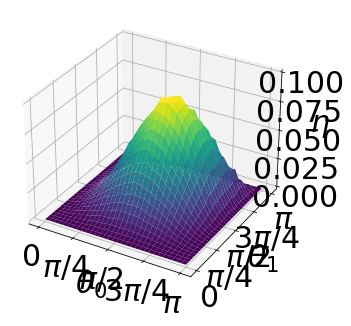

In [22]:
pi = np.pi
theta6 = np.linspace(0,1,split*2)
phi6 = np.linspace(0,1,split*2)

backend = 'simulator'
fig = plt.figure()
ax = Axes3D(fig)
x, y = np.meshgrid(theta6, phi6)
ax.set_xlabel('$\\theta_0$', fontsize=30)
ax.set_ylabel('$\\theta_1$',fontsize=30)
ax.set_zlabel('$\eta$', fontsize=30)
ax.set_zlim(zmax=0.1)
ax.tick_params(labelsize = 30)
ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)
import matplotlib.ticker as tck
positions = [0, 0.25, 0.5, 0.75, 1]
labels = ['0', '$\pi$/4', '$\pi$/2', '3$\pi$/4', '$\pi$']
ax.xaxis.set_major_locator(tck.FixedLocator(positions))
ax.xaxis.set_major_formatter(tck.FixedFormatter(labels))
ax.yaxis.set_major_locator(tck.FixedLocator(positions))
ax.yaxis.set_major_formatter(tck.FixedFormatter(labels))
ax.zaxis.set_major_locator(tck.MultipleLocator(base=0.025))
ax.plot_surface(x, y, z/10, rstride=1, cstride=1, cmap='viridis')
plt.savefig('figure/4%s.svg' % backend, transparent = True, dpi=240)

plt.show()

In [23]:
k0 =defaultdict(dict)
k1 =defaultdict(dict)
k2 =defaultdict(dict)
k3 =defaultdict(dict)
split = 8
repeat = np.arange(10)
for i in repeat:
    k0[i] = np.load(os.path.join('data', 'fig4', 'Vigo', '%s a.npy' % i))
    k1[i] = np.load(os.path.join('data', 'fig4', 'Vigo','%s a.npy' % (i+10)))
    k2[i] = np.load(os.path.join('data', 'fig4', 'Vigo','%s a.npy' % (i+20)))
    k3[i] = np.load(os.path.join('data', 'fig4', 'Vigo','%s a.npy' % (i+30)))
    
x=np.arange(0,split)
y=np.arange(0,split)
lx = len(x)
ly = len(y)
z0=np.zeros((lx,ly))
z1=np.zeros((lx,ly))
z2=np.zeros((lx,ly))
z3=np.zeros((lx,ly))
for i in repeat:
    z0=z0+k0[i]
    z1=z1+k1[i]
    z2=z2+k2[i]
    z3=z3+k3[i]
    
z = np.bmat([[z0, z1], [z2, z3]])

#variance from 10 times
var10_0 = np.var([x for x in k0.values()],axis=0)
var10_1 = np.var([x for x in k1.values()],axis=0)
var10_2 = np.var([x for x in k2.values()],axis=0)
var10_3 = np.var([x for x in k3.values()],axis=0)

#variance from 8192 shots
var81923d_0=([(x/10*(1-x/10)**2/8191+(1-x/10)*(x/10)**2/8191) for x in list(z0)])
var81923d_1=([(x/10*(1-x/10)**2/8191+(1-x/10)*(x/10)**2/8191) for x in list(z1)])
var81923d_2=([(x/10*(1-x/10)**2/8191+(1-x/10)*(x/10)**2/8191) for x in list(z2)])
var81923d_3=([(x/10*(1-x/10)**2/8191+(1-x/10)*(x/10)**2/8191) for x in list(z3)])

#adding variance and calculate std
from operator import add

std3d_0 = (np.sqrt(list( map(add, var10_0, var81923d_0) )))
std3d_1 = (np.sqrt(list( map(add, var10_1, var81923d_1) )))
std3d_2 = (np.sqrt(list( map(add, var10_2, var81923d_2) )))
std3d_3 = (np.sqrt(list( map(add, var10_3, var81923d_3) )))

err3d = np.bmat([[std3d_0, std3d_1], [std3d_2, std3d_3]])

C:\Users\tmduc\AppData\Local\Temp/ipykernel_5076/195286021.py:7: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


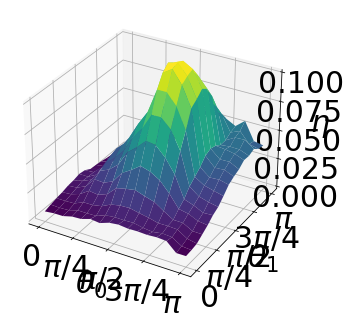

In [24]:
pi = np.pi
theta6 = np.linspace(0,1,split*2)
phi6 = np.linspace(0,1,split*2)

backend = 'vigo'
fig = plt.figure()
ax = Axes3D(fig)
x, y = np.meshgrid(theta6, phi6)
ax.set_xlabel('$\\theta_0$', fontsize=30)
ax.set_ylabel('$\\theta_1$',fontsize=30)
ax.set_zlabel('$\eta$', fontsize=30)
ax.set_zlim(zmin=0,zmax=0.1)
ax.tick_params(labelsize = 30)
ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)
import matplotlib.ticker as tck
positions = [0, 0.25, 0.5, 0.75, 1]
labels = ['0', '$\pi$/4', '$\pi$/2', '3$\pi$/4', '$\pi$']
ax.xaxis.set_major_locator(tck.FixedLocator(positions))
ax.xaxis.set_major_formatter(tck.FixedFormatter(labels))
ax.yaxis.set_major_locator(tck.FixedLocator(positions))
ax.yaxis.set_major_formatter(tck.FixedFormatter(labels))
ax.zaxis.set_major_locator(tck.MultipleLocator(base=0.025))
ax.plot_surface(x, y, z/10, rstride=1, cstride=1, cmap='viridis')

plt.savefig('figure/4%s.svg' % backend, transparent = True, dpi=240)

plt.show()

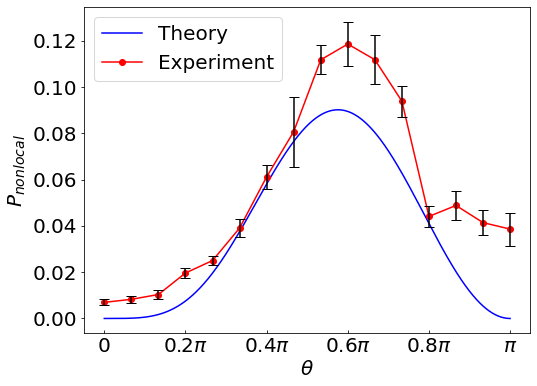

In [25]:
fig, ax = plt.subplots(figsize=(8,6))

#Theory
x= np.linspace(0,1,10**3)
y= 2*sin(x*pi/2)**4*cos(x*pi/2)**2/(3-cos(x*pi))
plt.plot(x,y,color='b',label='Theory')
#Experiment, theta = phi
hardy_prob = []
hardy_err = []
for i in range(len(theta6)):
    hardy_prob.append(z[i,i]/10)
    hardy_err.append(err3d[i,i])
plt.plot(theta6, hardy_prob,color='r',marker='o',label='Experiment')
plt.errorbar(theta6, hardy_prob, hardy_err,capsize=5, color='k',ls='none')

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,  # labels along the bottom edge are off
    direction="in", labelsize=20) 

plt.tick_params(axis="y", labelsize=20)
plt.xlabel(r'$\theta$', size=20)
plt.ylabel(r'$P_{nonlocal}$', size=20)
plt.legend(loc='upper left',fontsize=20)
xlocs, xlabs = plt.xticks()
plt.xticks([0,0.2,0.4,0.6,0.8,1], ['0', r'$0.2 \pi$', r'$0.4 \pi$', r'$0.6 \pi$', r'$0.8 \pi$', r'$\pi$'])
#ax.set_ylim(ymin=0.002,ymax=0.13)
#ax.set_xlim(xmin=-0.02,xmax=1.02)
#plt.grid()
#plt.gca().invert_xaxis()
plt.savefig('figure/4%s_2D.svg'%backend, dpi=240)
plt.show()

C:\Users\tmduc\AppData\Local\Temp/ipykernel_5076/1425149754.py:7: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


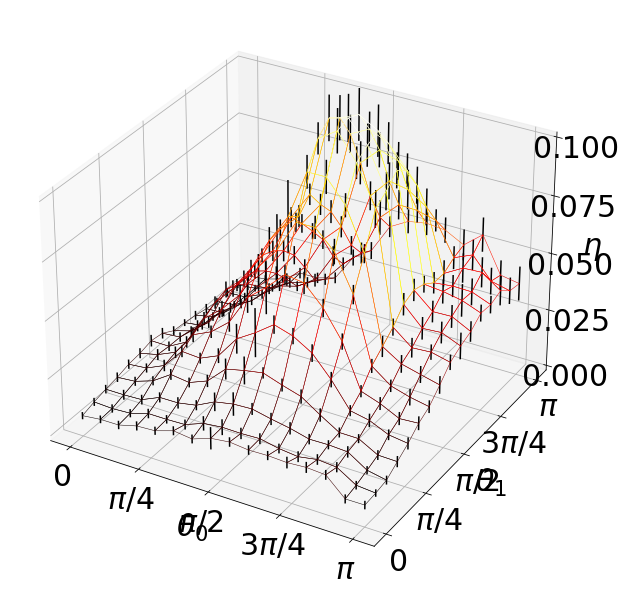

In [26]:
pi = np.pi
theta6 = np.linspace(0,1,split*2)
phi6 = np.linspace(0,1,split*2)

backend = 'vigo'
fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)
x, y = np.meshgrid(theta6, phi6)
ax.set_xlabel('$\\theta_0$', fontsize=30)
ax.set_ylabel('$\\theta_1$',fontsize=30)
ax.set_zlabel('$\eta$', fontsize=30)
ax.set_zlim(zmax=0.1)
ax.tick_params(labelsize = 30)
ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)
import matplotlib.ticker as tck
positions = [0, 0.25, 0.5, 0.75, 1]
labels = ['0', '$\pi$/4', '$\pi$/2', '3$\pi$/4', '$\pi$']
ax.xaxis.set_major_locator(tck.FixedLocator(positions))
ax.xaxis.set_major_formatter(tck.FixedFormatter(labels))
ax.yaxis.set_major_locator(tck.FixedLocator(positions))
ax.yaxis.set_major_formatter(tck.FixedFormatter(labels))
ax.zaxis.set_major_locator(tck.MultipleLocator(base=0.025))

from matplotlib import cm
norm = plt.Normalize(z.min(), z.max())
colors = cm.hot(norm(z))
surf = ax.plot_surface(x, y, z/10, rstride=1, cstride=1,linewidth=0.5,
                       shade=False,facecolors=colors)
surf.set_facecolor((0,0,0,0))
i=0
for p6 in phi6:
    j=0
    for t6 in theta6:
        ax.plot([t6, t6], [p6, p6], [(z[i,j]/10+err3d[i,j]),(z[i,j]/10-err3d[i,j])], color = 'k')
        j+=1
    i+=1

plt.savefig('figure/4%s_error.svg' % backend, transparent = True, dpi=240)
plt.show()